In [27]:

import os
import copy

import numpy as np
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'stix'
import matplotlib.pyplot as plt

import src.model_utils as mu
import lingam
import graphviz
from lingam.utils import make_prior_knowledge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
from importlib import reload
import netcomp as nc

import rdkit 
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from IPython.display import SVG

from sklearn.decomposition import PCA


import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=ConvergenceWarning)

os.environ["PATH"]+=':/opt/homebrew/bin'

# Demonstration of active learning workflow

1. Load each data subset
2. Down-select features
3. Active learning to match global adjacency matrix 

## Load the entire featurized QM9 dataset and each data split 

In [2]:
data_path = '../data/processed/'

In [5]:
all_data = [pd.read_csv(os.path.join(data_path,'all_data.csv'))]
for i in range(3):
    all_data.append(pd.read_csv(os.path.join(data_path,'split_class_{0}.csv'.format(i))))
    

In [58]:
all_data[-1].columns

Index(['smiles', 'ExactMolWt', 'TPSA', 'MolLogP', 'NumValenceElectrons',
       'MaxPartialCharge', 'NHOHCount', 'NOCount', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'RingCount',
       'MolMR', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles',
       'NumAliphaticRings', 'NumSaturatedCarbocycles',
       'NumSaturatedHeterocycles', 'NumSaturatedRings', 'HeavyAtomMolWt',
       'polarizability', 'dipole'],
      dtype='object')

In [11]:
from importlib import reload
reload(mu)

# down-select features based on polarizability causal influence
_, ranked_features, _, _ = mu.select_features(all_data[0], nkeep=9,  target_column="polarizability", ignore_columns=["smiles", "dipole"])

# down-select based on dipole
# _, ranked_features, _, _ = mu.select_features(all_data[0], nkeep=9,  target_column="dipole", ignore_columns=["smiles", "polarizability"])

# some reasonable features
# ranked_features = ['NHOHCount','NumAliphaticCarbocycles','NumHeteroatoms','NOCount',
#                    'RingCount','NumValenceElectrons','HeavyAtomMolWt','ExactMolWt',
#                    'MaxPartialCharge','dipole']

Columns used for feature selection ['ExactMolWt', 'TPSA', 'MolLogP', 'NumValenceElectrons', 'MaxPartialCharge', 'NHOHCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'RingCount', 'MolMR', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'HeavyAtomMolWt', 'polarizability']
Columns kept after feature selection ['ExactMolWt', 'HeavyAtomMolWt', 'NumValenceElectrons', 'NumSaturatedRings', 'NOCount', 'NumHDonors', 'NumAliphaticRings', 'NumHeteroatoms', 'NumSaturatedCarbocycles', 'dipole']


## Generate DAGs for each data subset and the full dataset. 
Using the down-selected features based on polarizability, listed as `ranked_features`, we next build the DAGs using `LinGAM`. 

In [30]:
all_adj, all_df = [], []
for k in range(4):
    df_now = all_data[k][ranked_features]

    # run causal inference on down-selected features
    target_column_ind = list(df_now.columns).index('dipole')
    model = mu.causal_inference(df_now, target_col=target_column_ind)

    vis_adj = copy.copy(model.adjacency_matrix_)
    vis_adj[np.abs(vis_adj)<.1] = 0

    d = mu.make_graph(vis_adj, labels=list(df_now.columns))
    d.render('figures/data_subset_dag_{0}'.format(k))
    
    all_adj.append(model.adjacency_matrix_)
    all_df.append(all_data[k][['smiles']+ranked_features])


In [28]:
# get the global causal map
df_now = all_data[0][ranked_features]
target_column_ind = list(df_now.columns).index('dipole')
model = mu.causal_inference(df_now, target_col=target_column_ind)
global_adj = model.adjacency_matrix_

# simplify for visualization
vis_adj = copy.copy(global_adj)
vis_adj[np.abs(vis_adj)<.1] = 0
d = mu.make_graph(vis_adj, labels=list(df_now.columns))
d.render('figures/all_molecules_dag')

'figures/all_molecules_dag.pdf'

## Perform active learning loop 

In [31]:
np.random.seed = 11

In [32]:
all_gscores_active = []
all_scores_active = []
all_subsets_active = []
for k in range(10):
    n0 = 1
    rand_id = np.arange(len(all_df[0]))
    np.random.shuffle(rand_id)
    id0 = rand_id[:n0]

    active_df = all_df[0].loc[id0]
    active_df.reset_index(drop=True)
    n_iter=40

    active_out = mu.run_active_loop(all_df, active_df, n_iter, global_adj, 20)
    scores_active, gscores_active, choices_active, adjs_active, subsets_active, active_df = active_out
    
    all_gscores_active.append(gscores_active)
    all_scores_active.append(scores_active)
    all_subsets_active.append(subsets_active)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/Users/z6f/anaconda3/envs/causal_zf/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/z6f/anaconda3/envs/causal_zf/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:2307: RuntimeWarning: divide by zero encountered in divide
  + residuals_sum_squares / self.noise_variance_
/Users/z6f/anaconda3/envs/causal_zf/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:2306: RuntimeWarning: invalid value encountered in add
  n_samples * np.log(2 * np.pi * self.noise_variance_)


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [57]:
active_df.to_csv('../data/processed/sample_active_df_v2.csv')

## Perform the control (random) loop 

In [33]:
all_gscores_random = []
all_scores_random = []
all_subsets_random = []
for k in range(10):
    rand_df = all_df[0].loc[id0]
    rand_df.reset_index(drop=True)

    n_iter=40
    random_out = mu.run_random_loop(all_df, rand_df, n_iter, global_adj, 20)
    scores_random, gscores_random, choices_random, adjs_random, subsets_random, random_df = random_out
    
    all_gscores_random.append(gscores_random)
    all_scores_random.append(scores_random)
    all_subsets_random.append(subsets_random)
    

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

## Visualization 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


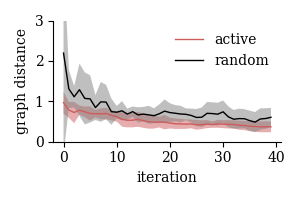

In [55]:
%matplotlib widget
f,ax = plt.subplots(figsize=(3,2))
mean_active = np.mean(all_gscores_active,axis=0)
std_active = np.std(all_gscores_active,axis=0)
ax.fill_between(np.arange(len(mean_active)), mean_active-std_active, mean_active+std_active,facecolor='indianred',alpha=0.5)
ax.plot(mean_active, c='indianred', linewidth=1, label='active')
# ax.plot(np.arange(len(mean_active)), np.array(all_gscores_active).T, linewidth=.2, c='indianred')

mean_random = np.mean(all_gscores_random,axis=0)
std_random = np.std(all_gscores_random,axis=0)
ax.fill_between(np.arange(len(mean_active)), mean_random-std_random, mean_random+std_random, facecolor='gray', alpha=0.5)
ax.plot(mean_random, c='k',linewidth=1, label='random')
# ax.plot(np.arange(len(mean_random)), np.array(all_gscores_random).T, linewidth=.2, c='gray')


# ax.plot(gscores_random,c='k',linewidth=1,linestyle='--',label='random')
ax.set_xlabel('iteration')
ax.set_ylabel('graph distance')
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim([0,3])
ax.legend(frameon=False,fontsize=10)
f.tight_layout()

# save the figures 
f.savefig('figures/active_vs_random_graph.eps')
f.savefig('figures/active_vs_random_graph.pdf')
f.savefig('figures/active_vs_random_graph.svg')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


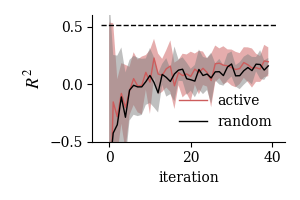

In [54]:
all_r2 = []
all_r2_rand = []
for k in range(10):
    for scores_active in all_scores_active:
        all_r2.append([score['R^2'] for score in scores_active])
    for scores_random in all_scores_random:
        all_r2_rand.append([score['R^2'] for score in scores_random])
    
r2_global = 0.51

f,ax = plt.subplots(figsize=(3,2))
mean_active = np.mean(all_r2,axis=0)
std_active = np.std(all_r2,axis=0)
ax.fill_between(np.arange(len(mean_active)), mean_active-std_active, mean_active+std_active,facecolor='indianred',alpha=0.5)
ax.plot(mean_active, c='indianred', linewidth=1, label='active')
# ax.plot(np.arange(len(mean_active)), np.array(all_gscores_active).T, linewidth=.2, c='indianred')

mean_random = np.mean(all_r2_rand,axis=0)
std_random = np.std(all_r2_rand,axis=0)
ax.fill_between(np.arange(len(mean_active)), mean_random-std_random, mean_random+std_random, facecolor='gray', alpha=0.5)
ax.plot(mean_random, c='k',linewidth=1, label='random')

ax.plot(ax.get_xlim(),[.51,.51],'k--',linewidth=1)
ax.set_ylim([-.5,.6])
ax.set_xlabel('iteration')
ax.set_ylabel('$R^2$',size=13)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False,fontsize=10)
f.tight_layout()

# save the figures 
f.savefig('figures/active_vs_random_r2.eps')
f.savefig('figures/active_vs_random_r2.pdf')
f.savefig('figures/active_vs_random_r2.svg')

3.2871018847940645 -2.581236353101046


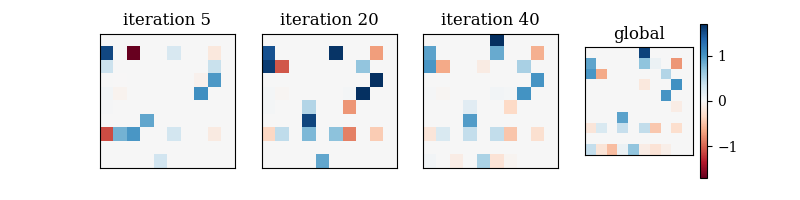

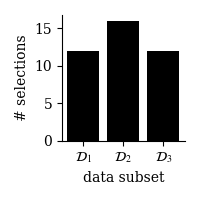

In [62]:
reload(mu)
mu.plot_iterative_adjs(adjs_active, global_adj, labels=df_now.columns.to_list())
mu.plot_subset_choices(subsets_active)


# Analysis of the chemical space 

In [47]:
# generate the ECFPs for the actively-learned dataset (better to only run once and save)
all_fp_active = []
for mol in active_df['smiles'].to_list():
    all_fp_active.append(mu.ECFP_from_smiles(mol))

In [50]:
# generate the ECFPs for each subset (better to only run once and save)
for i in range(1,4):
    X = mu.get_data_fingerprints(all_data[i], 'smiles')
    np.save(os.path.join(data_path,f'fingerprint_subset_{i}.npy'),X)
    

In [51]:
# describe the chemical space according to the entire QM9 dataset 
all_data_fp = np.load(os.path.join(data_path,'all_data_fp.npy'))
all_reducer = PCA(n_components=None, svd_solver='full')
all_reducer.fit(all_data_fp)
all_data_embedding = all_reducer.transform(all_data_fp)

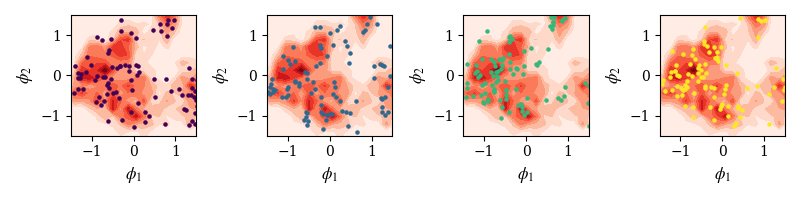

In [53]:
# plot the sampled data on the full embedding space 
reload(mu)
mu.plot_sampled_molecular_space(all_data_embedding, all_reducer.transform(all_fp_active))

1.0 0.0


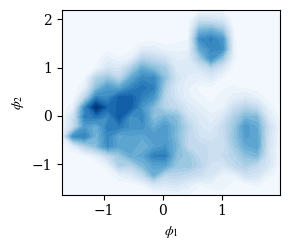

In [ ]:
# plot the chemical space based on ranked features from QM9
f, ax = plt.subplots(figsize=(3,2.6))
nsample = all_data_embedding.shape[0]//2
BCTX, BCTY, hist2d=mu.getcolordensity_contour(all_data_embedding[nsample:, 0], all_data_embedding[nsample:, 1])
print(np.max(hist2d),np.min(hist2d))
ax.contourf(BCTX, BCTY, hist2d, vmin=0.0, vmax=1,levels=25, cmap="Blues")#, alpha=0.5)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
f.tight_layout()


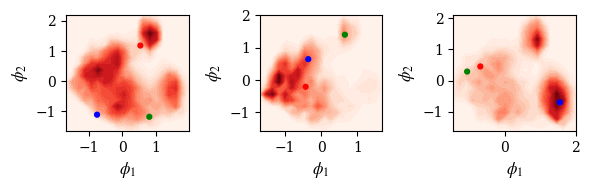

In [ ]:

f,ax = plt.subplots(1,3,figsize=(6,2))
all_inds = [[44872,  4549, 50746],[ 613,  4371, 34573],[24657,  6792, 25932]]
colors = ['r','g','b']
for i in range(1,4):
    X = np.load(os.path.join(data_path,'fingerprint_subset_{0}.npy'.format(i)))
    embedding = all_reducer.transform(X)
    BCTX, BCTY, hist2d=mu.getcolordensity_contour(embedding[:, 0], embedding[:, 1])
    # print(np.max(hist2d),np.min(hist2d))
    # hist2d[hist2d<.05] = np.nan
    inds = all_inds[i-1]
    ax[i-1].contourf(BCTX, BCTY, hist2d, vmin=0.0, vmax=1,levels=25, cmap="Reds")#, alpha=0.5)
    ax[i-1].scatter(embedding[inds,0],embedding[inds,1],c=colors,s=12)
    ax[i-1].set_xlabel('$\phi_1$',size=12)
    ax[i-1].set_ylabel('$\phi_2$',size=12)
    # draw the molecules
    mols = []
    for k in range(3):
        smiles = all_data[i]['smiles'].loc[k]
        molecule = Chem.MolFromSmiles(smiles)
        mols.append(molecule)
   # mu.draw_molecules(mols,'subset_{0}'.format(i))
f.tight_layout()

# save the figues 
# f.savefig('example_molecules_subsets.pdf')

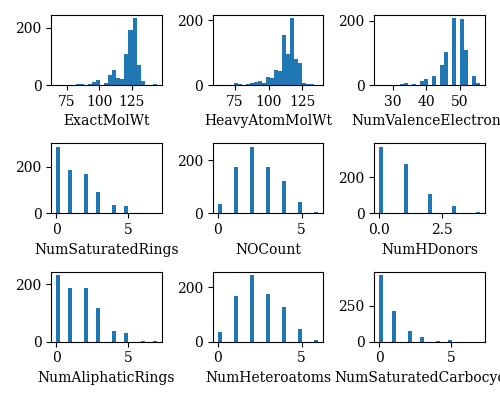

In [66]:
active_df.columns
columns = ['ExactMolWt', 'HeavyAtomMolWt', 'NumValenceElectrons',
       'NumSaturatedRings', 'NOCount', 'NumHDonors', 'NumAliphaticRings',
       'NumHeteroatoms', 'NumSaturatedCarbocycles']

f, ax = plt.subplots(3,3, figsize=(5,4))
ax = ax.flatten()
for i,column in enumerate(columns):
    ax[i].hist(active_df[column],bins=25)
    ax[i].set_xlabel(column)
f.tight_layout()
f.savefig('figures/active_feature_hists.eps')

    